Cutout Data Augmentation.

This code is implmented by following the official code (https://github.com/uoguelph-mlrg/Cutout)


##**Import all neceassary packages**

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import datasets, transforms

from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt


##**Model - Define ResNet Model**

In [3]:
'''ResNet18/34/50/101/152 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

def test_resnet():
    net = ResNet50()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

# test_resnet()

##**Utils**

In [4]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

##**Cutout: Main Code for Applying Cutout data augmentation**

In [4]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
        

## horizon décalcomanie


In [55]:
class RandomHorizonDecalcomanie(torch.nn.Module):


    def __init__(self, p=0.8):
        super().__init__()
        self.p = p

    def forward(self, img):

        if torch.rand(1) < self.p:

            if  torch.rand(1) < self.p:
              #vertical
              if torch.rand(1) < self.p:
                #left Decalcomanie
                  return torch.cat((img[:,:16,:32], torch.flip(img,[1])[:,16:,:32]), 1)
              else:
                #right Decalcomanie
                  return torch.cat(( torch.flip(img,[1])[:,:16,:32], img[:,16:,:32]), 1)
            else:
              #horizon
              if torch.rand(1) < self.p:
                #left Decalcomanie
                  return torch.cat((img[:,:32,:16], torch.flip(img,[2])[:,:32,16:]), 2)
              else:
                #right Decalcomanie
                  return torch.cat(( torch.flip(img,[2])[:,:32,:16], img[:,:32,16:]), 2)

        return img



In [16]:
x=torch.tensor([1,2,3,])
x[:3]

tensor([1, 2, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


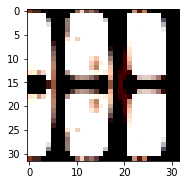

In [74]:
x1 = train_dataset[15][0]
plt.subplot(121)
plt.imshow(x1.permute(1,2,0))
# x2 = torch.flip(x1,[1])
# plt.subplot(122)
# plt.imshow(x2.permute(1,2,0))
# plt.show()

In [18]:
x1[:,:15,:].shape

torch.Size([3, 15, 32])

In [19]:
len(train_dataset)


50000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


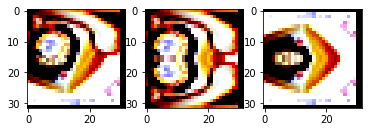

In [54]:
img = train_dataset[5][0]

plt.subplot(131)
plt.imshow(img.permute(1,2,0))

plt.subplot(132)

x =torch.cat((img[:,:16,:32], torch.flip(img,[1])[:,16:,:32]), 1)
plt.imshow(x.permute(1,2,0))
plt.subplot(133)
x =torch.cat(( torch.flip(img,[1])[:,:16,:32], img[:,16:,:32]), 1)
plt.imshow(x.permute(1,2,0))


In [21]:
print(torch.rand(1))
print(torch.rand(1))

tensor([0.5955])
tensor([0.6180])


In [22]:
x = torch.arange(8).view(2, 2, 2)
print(x)
print(torch.flip(x,[2]))


tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])
tensor([[[1, 0],
         [3, 2]],

        [[5, 4],
         [7, 6]]])


##**Parameter Settings**

In [5]:
dataset = 'cifar100' # cifar10 or cifar100
model = 'resnet34' # resnet18, resnet50, resnet101
batch_size = 128  # Input batch size for training (default: 128)
epochs = 150 # Number of epochs to train (default: 200)
learning_rate = 0.1 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
cutout = False # Apply Cutout?
mixup = False # Apply Mixup?
Decalcomanie = True # Apply Mixup?
n_holes = 1 # Number of holes to cut out from image
length = 16 # Length of the holes
seed = 0 # Random seed (default: 0)
print_freq = 30
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

test_id = dataset + '_' + model

##**Load and preprocess data**

In [62]:
# Image Preprocessing
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

train_transform = transforms.Compose([])
if data_augmentation:
    train_transform.transforms.append(transforms.RandomCrop(32, padding=4))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)
if Decalcomanie:
    train_transform.transforms.append(RandomHorizonDecalcomanie())

if cutout:
    train_transform.transforms.append(Cutout(n_holes=n_holes, length=length))


test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
    ])

if dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)
elif dataset == 'cifar100':
    num_classes = 100
    train_dataset = datasets.CIFAR100(root='data/',
                                      train=True,
                                      transform=train_transform,
                                      download=True)

    test_dataset = datasets.CIFAR100(root='data/',
                                     train=False,
                                     transform=test_transform,
                                     download=True)


# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## print image

In [29]:
input =  list(train_loader)[0]    


In [38]:
input[1]

tensor([ 0, 46, 36, 88,  8, 53, 43, 79,  3, 91, 98, 67, 25, 11, 18, 16, 66, 81,
        40, 51, 60, 85, 44, 70, 93, 75, 37, 54, 67, 40, 50, 84, 42, 43,  5, 40,
        60, 52, 42, 50, 92, 53, 84, 65, 63, 16, 52,  2, 80,  6, 53, 10, 50, 80,
        57, 51, 88, 18, 61, 53, 48, 84, 26, 46,  0,  7, 47, 59, 83,  0, 45, 31,
        43, 37, 17, 44, 55, 13, 20, 81, 97, 67, 50,  4, 19, 47,  7, 20, 41, 93,
        45, 99, 11, 56, 54, 13, 86, 29, 17, 79, 83, 21, 28, 24, 84, 53, 15, 32,
        85, 17, 14, 13, 10, 18, 10, 50, 48, 42, 37, 49, 42, 46, 66, 18, 68, 93,
         8, 82])

##**Main Training**

In [ ]:
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()
 
    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        target = target.cuda()
        if mixup:
          input, targets_a, targets_b, lam = mixup_data(input, target)



        # compute output
        output = model(input)
        if mixup:
          loss = mixup_criterion(criterion,output, targets_a,targets_b,lam)
          
        else:
          loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader,epoch, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(test_loader):
        input = input.cuda()
        target = target.cuda()

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Test Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

model = ResNet34(num_classes=num_classes).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)

scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

criterion = torch.nn.CrossEntropyLoss().cuda()

###########################################################
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    test_acc = test(test_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'model_best.pt')

torch.save(model.state_dict(),'model_latest.pt')
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 0, lr: 0.1 -----
Epoch: [0][  0/391]	Time  1.242 ( 1.242)	Loss 4.7454e+00 (4.7454e+00)	Acc@1   0.00 (  0.00)	Acc@5   4.69 (  4.69)
Epoch: [0][ 30/391]	Time  0.159 ( 0.190)	Loss 4.6094e+00 (5.1483e+00)	Acc@1   0.00 (  1.46)	Acc@5   4.69 (  6.02)
Epoch: [0][ 60/391]	Time  0.160 ( 0.175)	Loss 4.4914e+00 (4.8938e+00)	Acc@1   3.12 (  1.65)	Acc@5  15.62 (  6.86)
Epoch: [0][ 90/391]	Time  0.158 ( 0.170)	Loss 4.5027e+00 (4.7687e+00)	Acc@1   2.34 (  2.00)	Acc@5  11.72 (  8.04)
Epoch: [0][120/391]	Time  0.161 ( 0.167)	Loss 4.3688e+00 (4.6770e+00)	Acc@1   5.47 (  2.33)	Acc@5  15.62 (  9.47)
Epoch: [0][150/391]	Time  0.161 ( 0.166)	Loss 4.1970e+00 (4.6090e+00)	Acc@1   4.69 (  2.56)	Acc@5  15.62 ( 10.55)
Epoch: [0][180/391]	Time  0.159 ( 0.165)	Loss 4.1865e+00 (4.5527e+00)	Acc@1   7.03 (  2.76)	Acc@5  21.88 ( 11.62)
Epoch: [0][210/391]	Time  0.162 ( 0.165)	Loss 4.2443e+00 (4.5134e+00)	Acc@1   0.78 (  2.87)	Acc@5  14.06 ( 12.27)
Epoch: [0][240/391]	Time  0.164 ( 0.164)	Loss 4.1867e+00 